## Modelação do Random Forest com Grid Search

**Importação das bibliotecas**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold


**Leitura dos datasets preparados**

In [2]:
train_df = pd.read_csv("train_data_prepared.csv", encoding="latin-1",keep_default_na=False, na_values=['NULL', ''])
test_df = pd.read_csv("test_data_prepared.csv", encoding="latin-1",keep_default_na=False, na_values=['NULL', ''])

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6812 entries, 0 to 6811
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   AVERAGE_FREE_FLOW_SPEED  6812 non-null   float64
 1   AVERAGE_TIME_DIFF        6812 non-null   float64
 2   AVERAGE_FREE_FLOW_TIME   6812 non-null   float64
 3   LUMINOSITY               6812 non-null   int64  
 4   AVERAGE_TEMPERATURE      6812 non-null   float64
 5   AVERAGE_ATMOSP_PRESSURE  6812 non-null   float64
 6   AVERAGE_HUMIDITY         6812 non-null   float64
 7   AVERAGE_WIND_SPEED       6812 non-null   float64
 8   AVERAGE_CLOUDINESS       6812 non-null   int64  
 9   RAIN_INTENSITY           6812 non-null   int64  
 10  record_date_year         6812 non-null   int64  
 11  record_date_month        6812 non-null   int64  
 12  record_date_day          6812 non-null   int64  
 13  record_date_hour         6812 non-null   int64  
 14  day_of_week             

In [4]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   AVERAGE_FREE_FLOW_SPEED  1500 non-null   float64
 1   AVERAGE_TIME_DIFF        1500 non-null   float64
 2   AVERAGE_FREE_FLOW_TIME   1500 non-null   float64
 3   LUMINOSITY               1500 non-null   int64  
 4   AVERAGE_TEMPERATURE      1500 non-null   float64
 5   AVERAGE_ATMOSP_PRESSURE  1500 non-null   float64
 6   AVERAGE_HUMIDITY         1500 non-null   float64
 7   AVERAGE_WIND_SPEED       1500 non-null   float64
 8   AVERAGE_CLOUDINESS       1500 non-null   int64  
 9   RAIN_INTENSITY           1500 non-null   int64  
 10  record_date_year         1500 non-null   int64  
 11  record_date_month        1500 non-null   int64  
 12  record_date_day          1500 non-null   int64  
 13  record_date_hour         1500 non-null   int64  
 14  day_of_week             

In [5]:
print("Tamanho do treino:", train_df.shape)
print("Tamanho do teste:", test_df.shape)

Tamanho do treino: (6812, 33)
Tamanho do teste: (1500, 32)


**Separação das features e target**

In [6]:
X = train_df.drop(columns=["AVERAGE_SPEED_DIFF"])
y = train_df["AVERAGE_SPEED_DIFF"]

Distribuição das classes:
AVERAGE_SPEED_DIFF
0    2200
2    1651
1    1419
3    1063
4     479
Name: count, dtype: int64

Distribuição percentual (%):
AVERAGE_SPEED_DIFF
0    32.295948
2    24.236641
1    20.830887
3    15.604815
4     7.031709
Name: proportion, dtype: float64


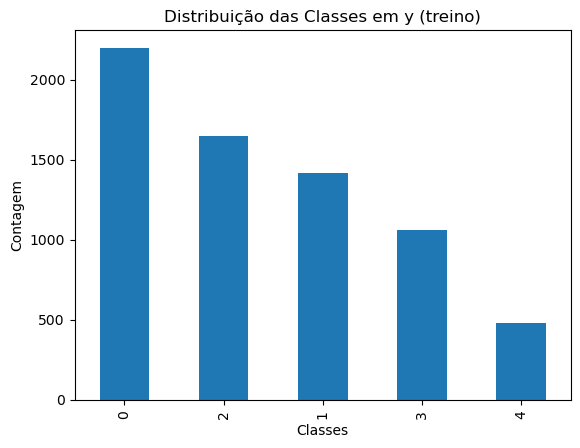

In [7]:
# Análise da distribuição das classes para verificar desbalanceamento

# Ver distribuição absoluta
print("Distribuição das classes:")
print(y.value_counts())

# Ver distribuição percentual
print("\nDistribuição percentual (%):")
print(y.value_counts(normalize=True) * 100)

# Visualização gráfica da distribuição de classes
y.value_counts().plot(kind='bar')
plt.title("Distribuição das Classes em y (treino)")
plt.xlabel("Classes")
plt.ylabel("Contagem")
plt.show()


**Definição do modelo Base e Grid Seacrh**

In [ ]:
class_weights = {
    0: 3.040,     
    1: 5.055,     
    2: 4.412,     
    3: 5.488,     
    4: 15.519     
}

rf = RandomForestClassifier(
    class_weight=class_weights,
    n_jobs=-1,
    random_state=42
)


Grid Search

In [ ]:
# Validação cruzada (5 folds estratificados)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# hiperparâmetros a testar
param_grid = {
    "n_estimators": [200, 300],
    "max_depth": [None,7,10],
    "min_samples_split": [2, 3],
    "min_samples_leaf": [2, 3],
    "max_features": ["sqrt"],
}

# Configuração do Grid Search
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="f1_weighted",   # mais adequada para dados desbalanceados
    n_jobs=-1,
    verbose=2,
    cv=cv    
)

# Treino do modelo
print("A iniciar o Grid Search...")
grid_search.fit(X, y)

# Resultados
print("\n Melhores parâmetros encontrados:")
print(grid_search.best_params_)
print("\n Melhor score de validação (F1-weighted):", round(grid_search.best_score_, 4))

# Guarda o melhor modelo já treinado
best_model = grid_search.best_estimator_

A iniciar o Grid Search...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

 Melhores parâmetros encontrados:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 300}

 Melhor score de validação (F1-weighted): 0.8032


In [10]:
final_scores = cross_val_score(
    best_model,
    X,
    y,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)

print("Accuracy por fold:", final_scores)
print("Accuracy média:", final_scores.mean())
print("Desvio padrão:", final_scores.std())


Accuracy por fold: [0.81144534 0.7945708  0.79809104 0.79221733 0.81350954]
Accuracy média: 0.8019668111393734
Desvio padrão: 0.00880740859080315


In [11]:
best_model.fit(X, y)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


**Previsão final no dataset de teste**

In [12]:
y_test_pred = best_model.predict(test_df)

In [13]:
# Mapeamento inverso (0–4 para as categorias originais)
reverse_mapping = {
    0: "None",
    1: "Low",
    2: "Medium",
    3: "High",
    4: "Very_High"
}

y_test_labels = pd.Series(y_test_pred).map(reverse_mapping)

**Gerar o ficheiro de submissão para o Kaggle**

In [14]:
submission = pd.DataFrame({
    "RowId": range(1, len(test_df) + 1),
    "Speed_Diff": y_test_labels
})

submission.to_csv("submission.csv", index=False)
print("\nFicheiro 'submission.csv' criado com sucesso!")


Ficheiro 'submission.csv' criado com sucesso!


**Ver a importância das features**

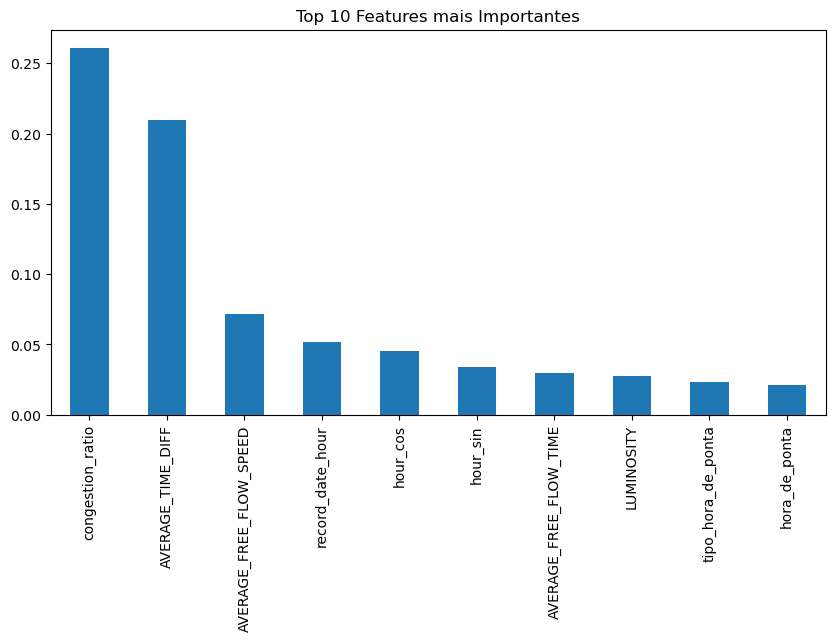

In [15]:
importances = pd.Series(best_model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10, 5))
importances.head(10).plot(kind="bar")
plt.title("Top 10 Features mais Importantes")
plt.show()

Accuracy no Kaggle: 0.80666